In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 14):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
flatten (Flatten)            (None, 512000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 512000)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                8192016   
Total params: 8,195,248
Trainable params: 8,195,248
Non-trainable params: 0
___________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 8000, 32)          3104      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 8000, 32)          3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 8000, 32)          3104      
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 8000, 32)          3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 8000, 32)          3104      
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 8000, 32)          3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_156 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_66 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 8000, 32)          3104      
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 8000, 32)          3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3515 - acc: 0.2442
Epoch 00001: val_loss improved from inf to 2.08062, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_3_conv_checkpoint/001-2.0806.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.3513 - acc: 0.2443 - val_loss: 2.0806 - val_acc: 0.3625
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9812 - acc: 0.3823
Epoch 00002: val_loss improved from 2.08062 to 1.86970, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_3_conv_checkpoint/002-1.8697.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.9811 - acc: 0.3823 - val_loss: 1.8697 - val_acc: 0.4223
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7388 - acc: 0.4727
Epoch 00003: val_loss improved from

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1334 - acc: 0.9610
Epoch 00028: val_loss did not improve from 1.55987
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1333 - acc: 0.9610 - val_loss: 2.8791 - val_acc: 0.5260
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1271 - acc: 0.9624
Epoch 00029: val_loss did not improve from 1.55987
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1271 - acc: 0.9625 - val_loss: 2.8930 - val_acc: 0.5262
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1232 - acc: 0.9638
Epoch 00030: val_loss did not improve from 1.55987
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1232 - acc: 0.9638 - val_loss: 2.9088 - val_acc: 0.5353
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1174 - acc: 0.9656
Epoch 00031: val_loss did not improve from 1.55987
36805/36805 [===========

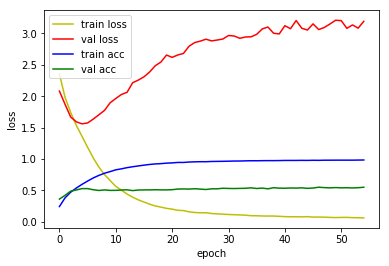

4815/4815 [==============================] - 3s 563us/sample - loss: 1.6396 - acc: 0.4926
Loss: 1.639625862281023 Accuracy: 0.4926272

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3635 - acc: 0.2445
Epoch 00001: val_loss improved from inf to 1.89961, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_4_conv_checkpoint/001-1.8996.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.3634 - acc: 0.2445 - val_loss: 1.8996 - val_acc: 0.4286
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6938 - acc: 0.4775
Epoch 00002: val_loss improved from 1.89961 to 1.56494, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_4_conv_checkpoint/002-1.5649.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.6939 - acc: 0.4775 - val_loss: 1.5649 - val_acc: 0.5160
Epoch 3/500
36800/36805 [===================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1649 - acc: 0.9478
Epoch 00028: val_loss did not improve from 1.38056
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1649 - acc: 0.9478 - val_loss: 2.1600 - val_acc: 0.6087
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1606 - acc: 0.9503
Epoch 00029: val_loss did not improve from 1.38056
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1606 - acc: 0.9503 - val_loss: 2.0616 - val_acc: 0.6219
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1557 - acc: 0.9507
Epoch 00030: val_loss did not improve from 1.38056
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1556 - acc: 0.9507 - val_loss: 2.0904 - val_acc: 0.6280
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1484 - acc: 0.9534
Epoch 00031: val_loss did not improve from 1.38056
36805/36805 [========================

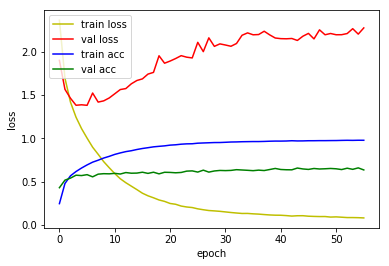

4815/4815 [==============================] - 3s 604us/sample - loss: 1.4313 - acc: 0.5512
Loss: 1.4313198433486845 Accuracy: 0.5511942

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4439 - acc: 0.2075
Epoch 00001: val_loss improved from inf to 2.09493, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_5_conv_checkpoint/001-2.0949.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 2.4438 - acc: 0.2076 - val_loss: 2.0949 - val_acc: 0.3326
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9541 - acc: 0.3813
Epoch 00002: val_loss improved from 2.09493 to 1.73149, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_5_conv_checkpoint/002-1.7315.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.9541 - acc: 0.3813 - val_loss: 1.7315 - val_acc: 0.4659
Epoch 3/500
36800/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1488 - acc: 0.9530
Epoch 00028: val_loss did not improve from 1.37296
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1489 - acc: 0.9530 - val_loss: 2.1645 - val_acc: 0.6047
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1445 - acc: 0.9541
Epoch 00029: val_loss did not improve from 1.37296
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1445 - acc: 0.9541 - val_loss: 2.0627 - val_acc: 0.6084
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1380 - acc: 0.9560
Epoch 00030: val_loss did not improve from 1.37296
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1380 - acc: 0.9560 - val_loss: 2.1733 - val_acc: 0.6010
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1303 - acc: 0.9592
Epoch 00031: val_loss did not improve from 1.37296
36805/36805 [========================

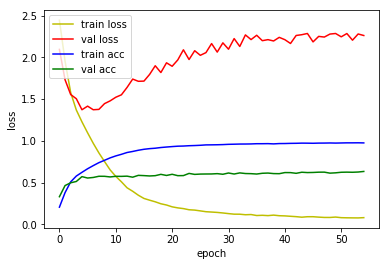

4815/4815 [==============================] - 3s 667us/sample - loss: 1.4565 - acc: 0.5335
Loss: 1.4564784374068707 Accuracy: 0.533541

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5348 - acc: 0.1719
Epoch 00001: val_loss improved from inf to 2.11840, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_6_conv_checkpoint/001-2.1184.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 2.5347 - acc: 0.1719 - val_loss: 2.1184 - val_acc: 0.3354
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8848 - acc: 0.4049
Epoch 00002: val_loss improved from 2.11840 to 1.60849, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_6_conv_checkpoint/002-1.6085.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.8847 - acc: 0.4049 - val_loss: 1.6085 - val_acc: 0.4845
Epoch 3/500
36800/36805 [===================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2998 - acc: 0.9041
Epoch 00025: val_loss did not improve from 0.98862
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.2998 - acc: 0.9041 - val_loss: 1.1486 - val_acc: 0.7116
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2839 - acc: 0.9097
Epoch 00026: val_loss did not improve from 0.98862
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.2840 - acc: 0.9097 - val_loss: 1.1267 - val_acc: 0.7279
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2666 - acc: 0.9143
Epoch 00027: val_loss did not improve from 0.98862
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.2666 - acc: 0.9144 - val_loss: 1.2860 - val_acc: 0.6953
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2521 - acc: 0.9179
Epoch 00028: val_loss did not improve from 0.98862
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1062 - acc: 0.9676
Epoch 00055: val_loss did not improve from 0.98862
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1062 - acc: 0.9676 - val_loss: 1.3281 - val_acc: 0.7517
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9653
Epoch 00056: val_loss did not improve from 0.98862
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1131 - acc: 0.9653 - val_loss: 1.4861 - val_acc: 0.7256
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1140 - acc: 0.9643
Epoch 00057: val_loss did not improve from 0.98862
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1140 - acc: 0.9643 - val_loss: 1.3298 - val_acc: 0.7480
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9666
Epoch 00058: val_loss did not improve from 0.98862
36805/36805 [===========

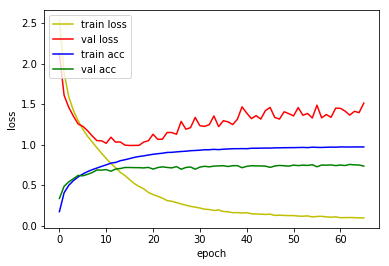

4815/4815 [==============================] - 3s 703us/sample - loss: 1.0802 - acc: 0.6827
Loss: 1.080234902385363 Accuracy: 0.6826584

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4353 - acc: 0.1951
Epoch 00001: val_loss improved from inf to 1.83527, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_7_conv_checkpoint/001-1.8353.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 2.4353 - acc: 0.1951 - val_loss: 1.8353 - val_acc: 0.4032
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6826 - acc: 0.4600
Epoch 00002: val_loss improved from 1.83527 to 1.40936, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_7_conv_checkpoint/002-1.4094.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.6827 - acc: 0.4600 - val_loss: 1.4094 - val_acc: 0.5558
Epoch 3/500
36800/36805 [===================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3824 - acc: 0.8841
Epoch 00024: val_loss did not improve from 0.62972
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.3823 - acc: 0.8841 - val_loss: 0.6359 - val_acc: 0.8274
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3519 - acc: 0.8918
Epoch 00025: val_loss did not improve from 0.62972
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.3520 - acc: 0.8918 - val_loss: 0.6500 - val_acc: 0.8337
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3306 - acc: 0.8981
Epoch 00026: val_loss did not improve from 0.62972
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.3306 - acc: 0.8981 - val_loss: 0.6445 - val_acc: 0.8390
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3153 - acc: 0.9033
Epoch 00027: val_loss did not improve from 0.62972
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9605
Epoch 00054: val_loss did not improve from 0.62972
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.1229 - acc: 0.9605 - val_loss: 0.7474 - val_acc: 0.8456
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1224 - acc: 0.9616
Epoch 00055: val_loss did not improve from 0.62972
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.1223 - acc: 0.9616 - val_loss: 0.7855 - val_acc: 0.8500
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1292 - acc: 0.9589
Epoch 00056: val_loss did not improve from 0.62972
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.1292 - acc: 0.9589 - val_loss: 0.7298 - val_acc: 0.8491
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1156 - acc: 0.9635
Epoch 00057: val_loss did not improve from 0.62972
36805/36805 [===========

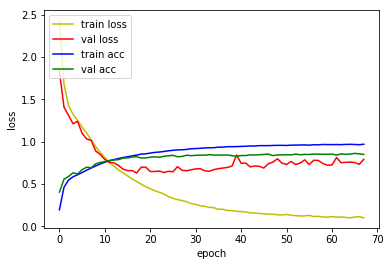

4815/4815 [==============================] - 3s 706us/sample - loss: 0.7538 - acc: 0.7873
Loss: 0.7537895601238912 Accuracy: 0.7873313

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5190 - acc: 0.1605
Epoch 00001: val_loss improved from inf to 2.00545, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_8_conv_checkpoint/001-2.0054.hdf5
36805/36805 [==============================] - 70s 2ms/sample - loss: 2.5190 - acc: 0.1605 - val_loss: 2.0054 - val_acc: 0.3613
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7545 - acc: 0.4258
Epoch 00002: val_loss improved from 2.00545 to 1.41750, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_8_conv_checkpoint/002-1.4175.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.7545 - acc: 0.4258 - val_loss: 1.4175 - val_acc: 0.5469
Epoch 3/500
36800/36805 [==================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4216 - acc: 0.8730
Epoch 00023: val_loss did not improve from 0.48920
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.4215 - acc: 0.8731 - val_loss: 0.5347 - val_acc: 0.8523
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4004 - acc: 0.8781
Epoch 00024: val_loss improved from 0.48920 to 0.47601, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_8_conv_checkpoint/024-0.4760.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.4004 - acc: 0.8781 - val_loss: 0.4760 - val_acc: 0.8679
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3827 - acc: 0.8826
Epoch 00025: val_loss did not improve from 0.47601
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.3827 - acc: 0.8826 - val_loss: 0.4818 - val_acc: 0.8686
Epoch 26/500
36800/36805 [============================>.] -

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1753 - acc: 0.9426
Epoch 00050: val_loss did not improve from 0.40138
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1753 - acc: 0.9426 - val_loss: 0.4247 - val_acc: 0.9038
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1737 - acc: 0.9439
Epoch 00051: val_loss did not improve from 0.40138
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1737 - acc: 0.9439 - val_loss: 0.4153 - val_acc: 0.9017
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1615 - acc: 0.9478
Epoch 00052: val_loss did not improve from 0.40138
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1615 - acc: 0.9478 - val_loss: 0.4304 - val_acc: 0.9012
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1620 - acc: 0.9475
Epoch 00053: val_loss did not improve from 0.40138
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1011 - acc: 0.9670
Epoch 00080: val_loss did not improve from 0.40138
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1011 - acc: 0.9670 - val_loss: 0.4313 - val_acc: 0.9115
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1026 - acc: 0.9668
Epoch 00081: val_loss did not improve from 0.40138
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1026 - acc: 0.9668 - val_loss: 0.4859 - val_acc: 0.9057
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1010 - acc: 0.9660
Epoch 00082: val_loss did not improve from 0.40138
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1010 - acc: 0.9660 - val_loss: 0.4358 - val_acc: 0.9189
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1015 - acc: 0.9672
Epoch 00083: val_loss did not improve from 0.40138
36805/36805 [===========

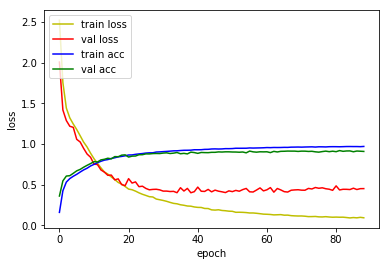

4815/4815 [==============================] - 4s 751us/sample - loss: 0.4481 - acc: 0.8731
Loss: 0.44814825140922365 Accuracy: 0.8731049

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5595 - acc: 0.1525
Epoch 00001: val_loss improved from inf to 2.23847, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_9_conv_checkpoint/001-2.2385.hdf5
36805/36805 [==============================] - 75s 2ms/sample - loss: 2.5594 - acc: 0.1525 - val_loss: 2.2385 - val_acc: 0.2690
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9424 - acc: 0.3604
Epoch 00002: val_loss improved from 2.23847 to 1.53353, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_9_conv_checkpoint/002-1.5335.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.9424 - acc: 0.3604 - val_loss: 1.5335 - val_acc: 0.5034
Epoch 3/500
36800/36805 [=================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3043 - acc: 0.9040
Epoch 00024: val_loss improved from 0.37458 to 0.35372, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_9_conv_checkpoint/024-0.3537.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.3043 - acc: 0.9040 - val_loss: 0.3537 - val_acc: 0.9092
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2845 - acc: 0.9109
Epoch 00025: val_loss did not improve from 0.35372
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.2845 - acc: 0.9109 - val_loss: 0.3688 - val_acc: 0.9015
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2766 - acc: 0.9119
Epoch 00026: val_loss did not improve from 0.35372
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.2766 - acc: 0.9119 - val_loss: 0.3736 - val_acc: 0.8947
Epoch 27/500
36800/36805 [============================>.] -

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1116 - acc: 0.9625
Epoch 00052: val_loss did not improve from 0.29210
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.1115 - acc: 0.9625 - val_loss: 0.3182 - val_acc: 0.9248
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1139 - acc: 0.9627
Epoch 00053: val_loss did not improve from 0.29210
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.1139 - acc: 0.9627 - val_loss: 0.3190 - val_acc: 0.9241
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1055 - acc: 0.9647
Epoch 00054: val_loss did not improve from 0.29210
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.1055 - acc: 0.9647 - val_loss: 0.3081 - val_acc: 0.9290
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1009 - acc: 0.9666
Epoch 00055: val_loss did not improve from 0.29210
36805/36805 [===========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9789
Epoch 00081: val_loss did not improve from 0.28066
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.0651 - acc: 0.9789 - val_loss: 0.3154 - val_acc: 0.9359
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0666 - acc: 0.9779
Epoch 00082: val_loss did not improve from 0.28066
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.0666 - acc: 0.9779 - val_loss: 0.3208 - val_acc: 0.9280
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9792
Epoch 00083: val_loss did not improve from 0.28066
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.0640 - acc: 0.9792 - val_loss: 0.3610 - val_acc: 0.9299
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9797
Epoch 00084: val_loss did not improve from 0.28066
36805/36805 [===========

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9867
Epoch 00111: val_loss did not improve from 0.28066
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.0427 - acc: 0.9867 - val_loss: 0.3431 - val_acc: 0.9378
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9846
Epoch 00112: val_loss did not improve from 0.28066
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.0474 - acc: 0.9846 - val_loss: 0.3110 - val_acc: 0.9383
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9870
Epoch 00113: val_loss did not improve from 0.28066
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.0411 - acc: 0.9870 - val_loss: 0.3054 - val_acc: 0.9394
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9862
Epoch 00114: val_loss did not improve from 0.28066
36805/36805 [=======

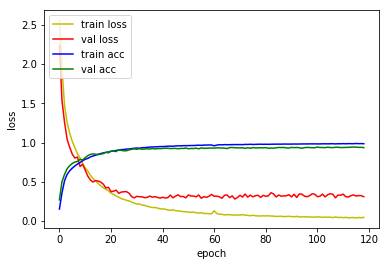

4815/4815 [==============================] - 4s 810us/sample - loss: 0.2989 - acc: 0.9248
Loss: 0.29892948167717714 Accuracy: 0.9248183

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6271 - acc: 0.1196
Epoch 00001: val_loss improved from inf to 2.28136, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_10_conv_checkpoint/001-2.2814.hdf5
36805/36805 [==============================] - 79s 2ms/sample - loss: 2.6269 - acc: 0.1197 - val_loss: 2.2814 - val_acc: 0.2916
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8824 - acc: 0.3779
Epoch 00002: val_loss improved from 2.28136 to 1.57365, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_10_conv_checkpoint/002-1.5736.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.8824 - acc: 0.3779 - val_loss: 1.5736 - val_acc: 0.4973
Epoch 3/500
36800/36805 [===============

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2373 - acc: 0.9239
Epoch 00023: val_loss did not improve from 0.24261
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.2373 - acc: 0.9239 - val_loss: 0.2646 - val_acc: 0.9241
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2356 - acc: 0.9241
Epoch 00024: val_loss improved from 0.24261 to 0.22974, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_10_conv_checkpoint/024-0.2297.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2355 - acc: 0.9241 - val_loss: 0.2297 - val_acc: 0.9359
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2217 - acc: 0.9275
Epoch 00025: val_loss improved from 0.22974 to 0.22833, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_10_conv_checkpoint/025-0.2283.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0988 - acc: 0.9661
Epoch 00049: val_loss improved from 0.18365 to 0.18266, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_10_conv_checkpoint/049-0.1827.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0987 - acc: 0.9661 - val_loss: 0.1827 - val_acc: 0.9546
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0964 - acc: 0.9675
Epoch 00050: val_loss did not improve from 0.18266
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0965 - acc: 0.9675 - val_loss: 0.2241 - val_acc: 0.9434
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0959 - acc: 0.9678
Epoch 00051: val_loss did not improve from 0.18266
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0959 - acc: 0.9678 - val_loss: 0.1982 - val_acc: 0.9509
Epoch 52/500
36800/36805 [============================>.] 

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0546 - acc: 0.9820
Epoch 00078: val_loss did not improve from 0.18199
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0546 - acc: 0.9820 - val_loss: 0.2087 - val_acc: 0.9560
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0523 - acc: 0.9827
Epoch 00079: val_loss did not improve from 0.18199
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0523 - acc: 0.9827 - val_loss: 0.2217 - val_acc: 0.9532
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9818
Epoch 00080: val_loss did not improve from 0.18199
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0516 - acc: 0.9818 - val_loss: 0.2067 - val_acc: 0.9536
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9832
Epoch 00081: val_loss did not improve from 0.18199
36805/36805 [===========

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9881
Epoch 00108: val_loss did not improve from 0.18199
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0346 - acc: 0.9881 - val_loss: 0.2299 - val_acc: 0.9515
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9861
Epoch 00109: val_loss did not improve from 0.18199
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0423 - acc: 0.9861 - val_loss: 0.2311 - val_acc: 0.9560
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9878
Epoch 00110: val_loss did not improve from 0.18199
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0351 - acc: 0.9878 - val_loss: 0.2322 - val_acc: 0.9557
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9881
Epoch 00111: val_loss did not improve from 0.18199
36805/36805 [=======

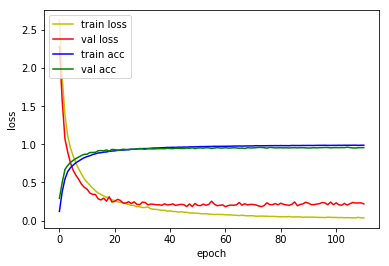

4815/4815 [==============================] - 4s 824us/sample - loss: 0.2158 - acc: 0.9398
Loss: 0.2158330811177954 Accuracy: 0.93977153

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6387 - acc: 0.1130
Epoch 00001: val_loss improved from inf to 2.31623, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_11_conv_checkpoint/001-2.3162.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.6387 - acc: 0.1129 - val_loss: 2.3162 - val_acc: 0.2427
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9077 - acc: 0.3650
Epoch 00002: val_loss improved from 2.31623 to 1.24552, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_11_conv_checkpoint/002-1.2455.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.9076 - acc: 0.3650 - val_loss: 1.2455 - val_acc: 0.5912
Epoch 3/500
36800/36805 [===============

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2296 - acc: 0.9251
Epoch 00024: val_loss did not improve from 0.20303
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.2296 - acc: 0.9251 - val_loss: 0.2065 - val_acc: 0.9443
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2219 - acc: 0.9279
Epoch 00025: val_loss did not improve from 0.20303
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.2219 - acc: 0.9279 - val_loss: 0.2058 - val_acc: 0.9436
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2123 - acc: 0.9314
Epoch 00026: val_loss did not improve from 0.20303
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.2123 - acc: 0.9314 - val_loss: 0.2354 - val_acc: 0.9294
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2074 - acc: 0.9337
Epoch 00027: val_loss improved from 0.20303 to 0.18399, saving model to mod

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0974 - acc: 0.9673
Epoch 00052: val_loss did not improve from 0.15775
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0974 - acc: 0.9673 - val_loss: 0.2065 - val_acc: 0.9474
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9679
Epoch 00053: val_loss did not improve from 0.15775
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0945 - acc: 0.9679 - val_loss: 0.1630 - val_acc: 0.9571
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0900 - acc: 0.9690
Epoch 00054: val_loss did not improve from 0.15775
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0900 - acc: 0.9690 - val_loss: 0.1595 - val_acc: 0.9569
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9696
Epoch 00055: val_loss did not improve from 0.15775
36805/36805 [===========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9784
Epoch 00081: val_loss did not improve from 0.15475
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0676 - acc: 0.9784 - val_loss: 0.1686 - val_acc: 0.9613
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9834
Epoch 00082: val_loss did not improve from 0.15475
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0479 - acc: 0.9834 - val_loss: 0.1597 - val_acc: 0.9602
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9829
Epoch 00083: val_loss did not improve from 0.15475
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0498 - acc: 0.9829 - val_loss: 0.1913 - val_acc: 0.9590
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9828
Epoch 00084: val_loss did not improve from 0.15475
36805/36805 [===========

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9889
Epoch 00111: val_loss did not improve from 0.15475
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0341 - acc: 0.9889 - val_loss: 0.2004 - val_acc: 0.9583
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9901
Epoch 00112: val_loss did not improve from 0.15475
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0315 - acc: 0.9901 - val_loss: 0.1924 - val_acc: 0.9583
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9886
Epoch 00113: val_loss did not improve from 0.15475
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0341 - acc: 0.9886 - val_loss: 0.1955 - val_acc: 0.9609
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9888
Epoch 00114: val_loss did not improve from 0.15475
36805/36805 [=======

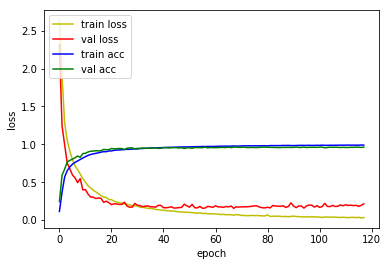

4815/4815 [==============================] - 4s 896us/sample - loss: 0.2224 - acc: 0.9454
Loss: 0.22243543011586056 Accuracy: 0.945379

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6495 - acc: 0.1140
Epoch 00001: val_loss improved from inf to 2.20679, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_12_conv_checkpoint/001-2.2068.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 2.6495 - acc: 0.1141 - val_loss: 2.2068 - val_acc: 0.3086
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9369 - acc: 0.3621
Epoch 00002: val_loss improved from 2.20679 to 1.44663, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_12_conv_checkpoint/002-1.4466.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 1.9368 - acc: 0.3621 - val_loss: 1.4466 - val_acc: 0.5367
Epoch 3/500
36800/36805 [================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2283 - acc: 0.9252
Epoch 00022: val_loss improved from 0.19309 to 0.19238, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_12_conv_checkpoint/022-0.1924.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.2283 - acc: 0.9253 - val_loss: 0.1924 - val_acc: 0.9397
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2144 - acc: 0.9301
Epoch 00023: val_loss improved from 0.19238 to 0.18496, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_12_conv_checkpoint/023-0.1850.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.2144 - acc: 0.9301 - val_loss: 0.1850 - val_acc: 0.9446
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2131 - acc: 0.9319
Epoch 00024: val_loss did not improve from 0.18496
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.2131 - acc: 0

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9738
Epoch 00049: val_loss did not improve from 0.15126
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0788 - acc: 0.9738 - val_loss: 0.1653 - val_acc: 0.9557
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0815 - acc: 0.9722
Epoch 00050: val_loss did not improve from 0.15126
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0815 - acc: 0.9722 - val_loss: 0.1599 - val_acc: 0.9571
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0763 - acc: 0.9737
Epoch 00051: val_loss did not improve from 0.15126
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0763 - acc: 0.9736 - val_loss: 0.1705 - val_acc: 0.9543
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0733 - acc: 0.9758
Epoch 00052: val_loss did not improve from 0.15126
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9860
Epoch 00078: val_loss did not improve from 0.14901
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0412 - acc: 0.9860 - val_loss: 0.1636 - val_acc: 0.9632
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9846
Epoch 00079: val_loss did not improve from 0.14901
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0437 - acc: 0.9846 - val_loss: 0.1727 - val_acc: 0.9609
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9875
Epoch 00080: val_loss did not improve from 0.14901
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0375 - acc: 0.9875 - val_loss: 0.1781 - val_acc: 0.9630
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9869
Epoch 00081: val_loss did not improve from 0.14901
36805/36805 [========================

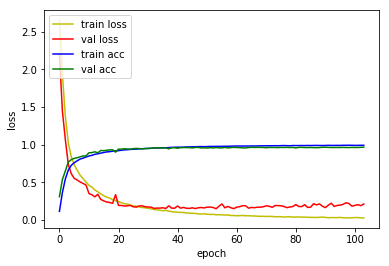

4815/4815 [==============================] - 4s 889us/sample - loss: 0.2326 - acc: 0.9435
Loss: 0.2325756860438537 Accuracy: 0.9435099

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4847 - acc: 0.1740
Epoch 00001: val_loss improved from inf to 1.89926, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_13_conv_checkpoint/001-1.8993.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 2.4846 - acc: 0.1741 - val_loss: 1.8993 - val_acc: 0.3781
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5465 - acc: 0.4927
Epoch 00002: val_loss improved from 1.89926 to 0.97407, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_13_conv_checkpoint/002-0.9741.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.5465 - acc: 0.4927 - val_loss: 0.9741 - val_acc: 0.6781
Epoch 3/500
36800/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1839 - acc: 0.9386
Epoch 00023: val_loss improved from 0.23983 to 0.22725, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_13_conv_checkpoint/023-0.2272.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1839 - acc: 0.9386 - val_loss: 0.2272 - val_acc: 0.9278
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1781 - acc: 0.9404
Epoch 00024: val_loss improved from 0.22725 to 0.22714, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_13_conv_checkpoint/024-0.2271.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1782 - acc: 0.9404 - val_loss: 0.2271 - val_acc: 0.9366
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1688 - acc: 0.9440
Epoch 00025: val_loss did not improve from 0.22714
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1689 - acc: 0

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0778 - acc: 0.9743
Epoch 00051: val_loss did not improve from 0.19607
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0778 - acc: 0.9744 - val_loss: 0.2451 - val_acc: 0.9467
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0504 - acc: 0.9835
Epoch 00052: val_loss did not improve from 0.19607
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0504 - acc: 0.9835 - val_loss: 0.2550 - val_acc: 0.9476
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9838
Epoch 00053: val_loss did not improve from 0.19607
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0487 - acc: 0.9838 - val_loss: 0.2948 - val_acc: 0.9436
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0519 - acc: 0.9829
Epoch 00054: val_loss did not improve from 0.19607
36805/36805 [===========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9895
Epoch 00081: val_loss did not improve from 0.19607
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0358 - acc: 0.9895 - val_loss: 0.2771 - val_acc: 0.9471
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9909
Epoch 00082: val_loss did not improve from 0.19607
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0297 - acc: 0.9909 - val_loss: 0.3575 - val_acc: 0.9336
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9913
Epoch 00083: val_loss did not improve from 0.19607
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0266 - acc: 0.9913 - val_loss: 0.2802 - val_acc: 0.9532
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9917
Epoch 00084: val_loss did not improve from 0.19607
36805/36805 [===========

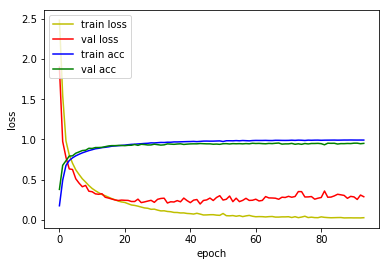

4815/4815 [==============================] - 5s 981us/sample - loss: 0.2804 - acc: 0.9321
Loss: 0.28042409526085554 Accuracy: 0.93208724



In [10]:
base = '1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO'
    
for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 14):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 8000, 32)          3104      
_________________________________________________________________
conv1d_187 (Conv1D)  

4815/4815 [==============================] - 5s 984us/sample - loss: 1.0802 - acc: 0.6827
Loss: 1.080234902385363 Accuracy: 0.6826584

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_218 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_220 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_92 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_222 (Conv1D)

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2989 - acc: 0.9248
Loss: 0.29892948167717714 Accuracy: 0.9248183

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_268 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_269 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_113 (MaxPoolin (None, 8000, 32)          0         
_________________________________________________________________
conv1d_270 (Conv1D

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2224 - acc: 0.9454
Loss: 0.22243543011586056 Accuracy: 0.945379

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_310 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_311 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_132 (MaxPoolin (None, 8000, 32)          0         
_________________________________________________________________
conv1d_312 (Conv1D)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2804 - acc: 0.9321
Loss: 0.28042409526085554 Accuracy: 0.93208724


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 8000, 32)          3104      
_________________________________________________________________
conv1d_187 (Conv1D)  

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.6355 - acc: 0.6972
Loss: 1.6355090392093916 Accuracy: 0.69719625

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_218 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_220 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_92 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_222 (Conv1D)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3444 - acc: 0.9248
Loss: 0.3444039510479845 Accuracy: 0.9248183

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_268 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_269 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_113 (MaxPoolin (None, 8000, 32)          0         
_________________________________________________________________
conv1d_270 (Conv1D)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2687 - acc: 0.9481
Loss: 0.2687434640010917 Accuracy: 0.94807893

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_310 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_311 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_132 (MaxPoolin (None, 8000, 32)          0         
_________________________________________________________________
conv1d_312 (Conv1D

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.4002 - acc: 0.9364
Loss: 0.4001683564795721 Accuracy: 0.9364486
